# Summary assignment - part 2

### Odeya Hazani- 207288457
### Roni Epstein- 211645825
### https://github.com/RoniEpstein/Data-mining-and-machine-learning-assignment

In [93]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import cleaning_funs #Python file attached
import column_prediction_models #Python file attached

import warnings
warnings.filterwarnings("ignore")

In [94]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict, RepeatedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer,explained_variance_score
import joblib

## Data Preparation

In [95]:
df_original= pd.read_csv('dataset.csv')
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   774 non-null    object 
 8   Curr_ownership   774 non-null    object 
 9   Area             1361 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            787 non-null    object 
 17  Km            

## prepare_data

In [96]:
def prepare_data(df):
    """The prepare_data function preprocesses a dataset for modeling using utilities from the cleaning_funs module. It cleans text, 
        processes categories, converts data types, and generates new features such as car age. 
        The function also selects relevant columns and fills missing values, 
        ensuring the data is ready for analysis."""
    
    # Ensure 'Description' column is of type string
    df['Description'] = df['Description'].astype('string')
    
    # Apply text cleaning functions
    df['Description'] = df['Description'].apply(cleaning_funs.clean_text_robust)
    df['model'] = df['model'].apply(cleaning_funs.clean_text_robust)
    
    # Clean 'capacity_Engine' column
    df['capacity_Engine'] = df['capacity_Engine'].replace(',', '', regex=True)
    
    # Apply custom functions to handle least frequent categories and conversions
    df = cleaning_funs.Color_least_frequent(df, 'Color', 'Processed_Colors')
    df = cleaning_funs.Engine_type_least_frequent(df, 'Engine_type')
    df = cleaning_funs.ownership_least_frequent(df, 'Curr_ownership', 'Processed_Curr_ownership')
    df = cleaning_funs.ownership_least_frequent(df, 'Prev_ownership', 'Processed_Prev_ownership')
    df = cleaning_funs.convert_to_date_and_calculate_days_and_check(df, 'Cre_date')
    df = cleaning_funs.convert_to_date_and_calculate_days_and_check(df, 'Repub_date')
    df = cleaning_funs.convert_Km(df, 'Km', 'Processed_Km')
    df = cleaning_funs.process_gear_column(df)
    df = cleaning_funs.process_manufactor_column(df)
    df = cleaning_funs.Processed_Test(df)
    df = cleaning_funs.process_accident_column(df, 'Description')
    df = cleaning_funs.convert_cap(df, 'capacity_Engine', 'Processed_capacity_Engine')
    df = cleaning_funs.update_description_length(df, 'Description', 'description_length')
    
    # Combine ownership columns
    df['Total_Ownership'] = df['Processed_Prev_ownership'].fillna('') + '_' + df['Processed_Curr_ownership']
    
    # Extract and process additional features
    df['dats_Test'] = df['Description'].apply(cleaning_funs.extract_test_dates_extended)
    df['Processed_Test'] = df.apply(cleaning_funs.apply_days_until_end_of_month, axis=1)
    df['Processed_model'] = df['model'].apply(cleaning_funs.translate_model)
    
    # Convert columns to appropriate types
    df['Total_Ownership'] = df['Total_Ownership'].astype('category')
    df['Processed_model'] = df['Processed_model'].astype('category')
    df['Processed_manufactor'] = df['Processed_manufactor'].astype('category')
    df['Processed_Gear'] = df['Processed_Gear'].astype('category')
    df['Processed_Colors'] = df['Processed_Colors'].astype('category')
    df['Processed_Engine_type'] = df['Processed_Engine_type'].astype('category')
    df['Processed_Curr_ownership'] = df['Processed_Curr_ownership'].astype('category')
    df['Processed_Prev_ownership'] = df['Processed_Prev_ownership'].astype('category')
    df['Processed_Test'] = pd.to_numeric(df['Processed_Test'], errors='coerce').astype('Int64')
    df = cleaning_funs.map_areas(df)
    df['Processed_Area'] = df['Processed_Area'].astype('category')
    df = cleaning_funs.fill_supply_score(df) #Processed_Supply_score
    # Create new features
    df['Car_Age'] = datetime.datetime.now().year - df['Year']
    df = cleaning_funs.convert_to_date_for_age(df, 'Repub_date')
    
    # Define the columns to copy
    columns_to_copy = [
        'Price', 'Car_Age', 'Hand', 'Pic_num', 'Processed_Supply_score', 'description_length', 
        'Processed_Colors','Processed_Engine_type', 'Processed_Area', 'Processed_Repub_date', 'Processed_capacity_Engine', 
        'Processed_Km', 'Processed_Gear','Processed_manufactor', 'Processed_Test', 'Processed_accident','Processed_model',
        'Total_Ownership']
    
    # Select the relevant columns
    df_p = df[columns_to_copy]

    df_p = column_prediction_models.fill_missing_values_colors(df_p, 'Processed_Colors')
    df_p = column_prediction_models.fill_missing_values_ownership(df_p, 'Total_Ownership')

    return df_p

In [97]:
df_p = prepare_data(df_original)
df_p = df_p.drop_duplicates()
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1330 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Price                      1330 non-null   float64 
 1   Car_Age                    1330 non-null   int64   
 2   Hand                       1330 non-null   int64   
 3   Pic_num                    1306 non-null   float64 
 4   Processed_Supply_score     377 non-null    float64 
 5   description_length         1330 non-null   int64   
 6   Processed_Colors           1330 non-null   category
 7   Processed_Engine_type      1325 non-null   category
 8   Processed_Area             1330 non-null   category
 9   Processed_Repub_date       1287 non-null   float64 
 10  Processed_capacity_Engine  1293 non-null   Int64   
 11  Processed_Km               1253 non-null   Int64   
 12  Processed_Gear             1328 non-null   category
 13  Processed_manufactor       1330 n

## model Preparation

In [98]:
def remove_outliers(df, lower_quantile, upper_quantile, multiplier):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = numeric_columns.drop('Price', errors='ignore')
    outlier_indices = set()
    
    for column_name in numeric_columns:
        Q1 = df[column_name].quantile(lower_quantile)
        Q3 = df[column_name].quantile(upper_quantile)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
       
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index
        outlier_indices.update(outliers)
    
    df_cleaned = df.drop(index=outlier_indices)
    return df_cleaned

def create_datasets(df):
    # Define configurations
    configurations = [
        {'lower_quantile': 0.15, 'upper_quantile': 0.85, 'multiplier': 2.5, 'label': 'dataset_1'},
        {'lower_quantile': 0.27, 'upper_quantile': 0.89, 'multiplier': 1.6, 'label': 'dataset_2'},
        {'lower_quantile': 0.23, 'upper_quantile': 0.86, 'multiplier': 2.2, 'label': 'dataset_3'}]
    
    datasets = {}
    for config in configurations:
        datasets[config['label']] = remove_outliers(df, config['lower_quantile'], config['upper_quantile'], config['multiplier'])
    
    return datasets

In [99]:
datasets = create_datasets(df_p)
data1=datasets.get('dataset_1')
data2=datasets.get('dataset_2')
data3=datasets.get('dataset_3')
datasets = [data1,data2,data3]
for i in datasets:
    print(len(i))

1273
1185
1245


In [100]:
# Define features and target
X = data3.drop(columns=['Price','Processed_Supply_score','Processed_accident'])
y = data3['Price']

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

### param_distributions
regressor__alpha: This is the regularization strength parameter. The values of alpha are chosen using np.logspace(-3.5, -1, 10), which means 10 logarithmic values between 
10 ^-3.5 and 10^-1
 This range helps in finding the optimal value that makes the model both simple and accurate.

regressor__l1_ratio: This parameter controls the balance between L1 (Lasso) and L2 (Ridge) regularization. The values range from 0.1 to 0.9, with 9 values in total, to find the right balance between the two methods.

In [101]:
# Recommended splits based on observations
splits = [
    ('Split 1', 0.15, 0.2353),
    ('Split 2', 0.10, 0.2222)
]
scalers = {
    'StandardScaler': StandardScaler(),
}

# Define the expanded parameter grid
param_distributions = {
    'regressor__alpha': np.logspace(-3.5, -1, 13),  
    'regressor__l1_ratio': np.linspace(0.1, 0.9, 14) }

### scoring metrics
neg_mean_squared_error: Negative Mean Squared Error (MSE). This metric gives more weight to larger errors, making it suitable when we want to avoid large errors.
neg_mean_absolute_error: Negative Mean Absolute Error (MAE). This metric is less sensitive to large errors and measures the average error.
neg_root_mean_squared_error: Negative Root Mean Squared Error (RMSE). This metric is the square root of MSE, thus having the same units as the original data. Here, make_scorer is used to create a custom scorer that calculates RMSE with greater_is_better=False to turn it into a negative metric (since random search minimizes negative values).
r2: R-squared (R²). This metric indicates the proportion of variance in the data that the model explains. Values close to 1 indicate a good model.
explained_variance: Explained Variance. This metric is similar to R² and measures the portion of the total variance explained by the model.

In [102]:
# Define scoring metrics
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'r2': 'r2',
    'explained_variance': 'explained_variance'}

In [103]:
best_cv_rmse = np.inf
best_model_overall = None
best_params_overall = None
best_scaler_name = None
best_split_name = None

# Log transformation for numerical features
log_transformer = FunctionTransformer(np.log1p, validate=True)

for scaler_name, scaler in scalers.items():
    print(f"\nEvaluating scaler: {scaler_name}")

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('poly_transform', PolynomialFeatures(degree=2, include_bias=False)),  # Apply polynomial transformation
        ('scaler', scaler)])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # Handle categorical features

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet())])

    for split_name, test_size, val_size in splits:
        print(f"\nEvaluating {split_name} with test_size={test_size} and val_size={val_size}")

        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

        random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, cv=10, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True, random_state=42)
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        # Calculate standard deviation of cross-validation scores
        cv_rmse_scores = np.sqrt(-random_search.cv_results_['mean_test_neg_mean_squared_error'])
        val_std = np.std(cv_rmse_scores)
        print(f"Validation RMSE: {val_rmse}, Validation RMSE Std Dev: {val_std}")
        
        y_test_pred = best_model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_std = np.std(y_test - y_test_pred)
        print(f"Test RMSE:       {rmse_test},     Test RMSE Std Dev: {test_std}")

        print("Best parameters found: ", random_search.best_params_)

        if val_rmse < best_cv_rmse:
            best_cv_rmse = val_rmse
            best_model_overall = best_model
            best_params_overall = random_search.best_params_
            best_scaler_name = scaler_name
            best_split_name = split_name

print(f"\nBest model overall: Scaler: {best_scaler_name}, Split: {best_split_name}")
print(f"Best Cross-Validation RMSE: {best_cv_rmse}")
print(f"Best parameters: {best_params_overall}")

# Final model training with the best parameters
final_model = best_model_overall

# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(final_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f"\n10-Fold Cross-Validation RMSE scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores)}, Std Dev CV RMSE: {np.std(cv_rmse_scores)}")

# Fit the final model on the full training data
final_model.fit(X_train, y_train)

# Get feature names after One-Hot Encoding
preprocessor.fit(X_train)  # Fit the preprocessor to the training data
onehot_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
numerical_feature_names = preprocessor.transformers_[0][1]['poly_transform'].get_feature_names_out(numerical_features)
feature_names = list(numerical_feature_names) + list(onehot_feature_names)

# Validate number of features
importances = final_model.named_steps['regressor'].coef_

if len(feature_names) == len(importances):
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances['Absolute_Importance'] = feature_importances['Importance'].abs()  # Calculate absolute importance
    top_features = feature_importances.sort_values(by='Absolute_Importance', ascending=False).head(5)
else:
    print("The lengths of feature names and importances do not match.")


Evaluating scaler: StandardScaler

Evaluating Split 1 with test_size=0.15 and val_size=0.2353
Validation RMSE: 12325.921194251943, Validation RMSE Std Dev: 785.3095487140631
Test RMSE:       9468.055414350154,     Test RMSE Std Dev: 9459.505915121123
Best parameters found:  {'regressor__l1_ratio': 0.9, 'regressor__alpha': 0.009085175756516871}

Evaluating Split 2 with test_size=0.1 and val_size=0.2222
Validation RMSE: 11208.484036212289, Validation RMSE Std Dev: 593.9977428380873
Test RMSE:       9442.120116696893,     Test RMSE Std Dev: 9410.830247049014
Best parameters found:  {'regressor__l1_ratio': 0.7769230769230769, 'regressor__alpha': 0.005623413251903491}

Best model overall: Scaler: StandardScaler, Split: Split 2
Best Cross-Validation RMSE: 11208.484036212289
Best parameters: {'regressor__l1_ratio': 0.7769230769230769, 'regressor__alpha': 0.005623413251903491}

10-Fold Cross-Validation RMSE scores: [12661.38865316  9715.93052876  7938.97143115 13721.60814002
 11325.92166157 1

In [104]:
# Save the best model
joblib.dump(final_model, 'final_model.pkl')

# Load the saved model
loaded_model = joblib.load('final_model.pkl')

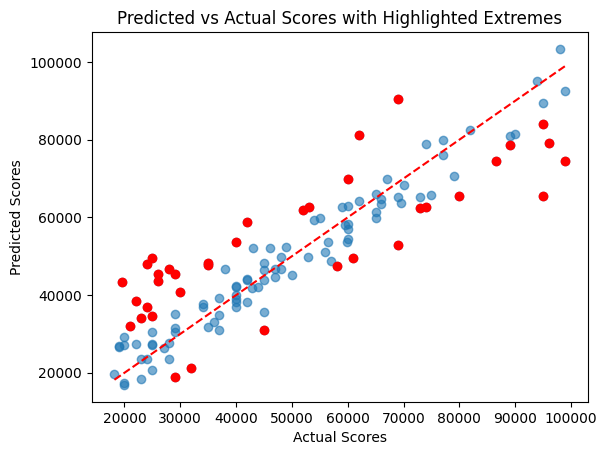

In [105]:
# Prediction on the test set
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, y_pred, alpha=0.6)

# Highlighting extremes
extreme_errors_indices = np.where(np.abs(residuals) > np.std(residuals))  # using std deviation as a threshold
plt.scatter(np.array(y_test)[extreme_errors_indices], np.array(y_pred)[extreme_errors_indices], color='red')

plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Predicted vs Actual Scores with Highlighted Extremes')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.show()

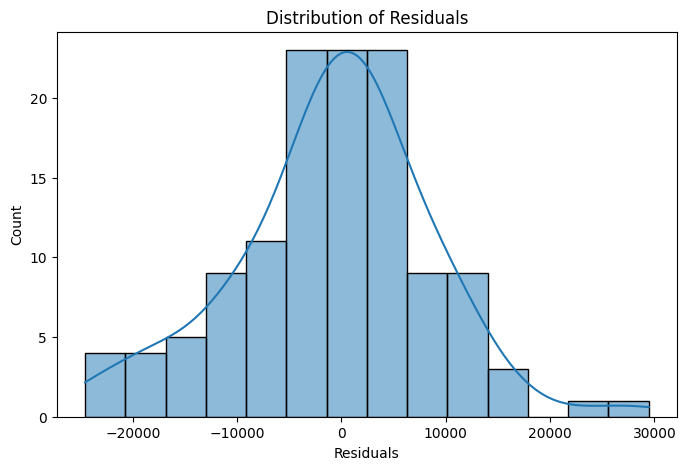

In [106]:
# Histogram of errors
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

In [107]:
# Model Performance Indicators on Full Data
y_pred = final_model.predict(X)
print("\nPerformance Metrics on Full Data:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, y_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, y_pred))}")
print(f"R-squared (R²): {r2_score(y, y_pred)}")


Performance Metrics on Full Data:
Mean Absolute Error (MAE): 6492.472805564621
Mean Squared Error (MSE): 80526473.24899527
Root Mean Squared Error (RMSE): 8973.654397679647
R-squared (R²): 0.8370474831310226


In [108]:
# Model Performance Indicators on Test Data
y_test_pred = final_model.predict(X_test)
print("\nPerformance Metrics on Test Data:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"R-squared (R²): {r2_score(y_test, y_test_pred)}")


Performance Metrics on Test Data:
Mean Absolute Error (MAE): 7086.597115398938
Mean Squared Error (MSE): 89153632.29813217
Root Mean Squared Error (RMSE): 9442.120116696893
R-squared (R²): 0.8208010152214491


## 5 top featuers

In [109]:
# Top 5 features based on absolute importance:
top_features

,Feature,Importance,Absolute_Importance
246,Processed_model_Space Star,-30050.165454,30050.165454
229,Processed_model_S-Class,22359.649377,22359.649377
0,Car_Age,-21646.132200,21646.132200
99,Processed_manufactor_מרצדס,20536.445282,20536.445282
97,Processed_manufactor_מיני,17808.392004,17808.392004


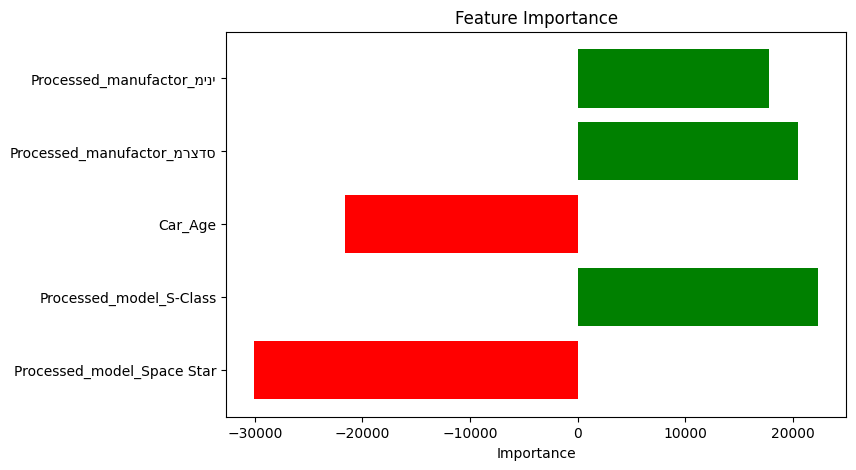

In [110]:
plt.figure(figsize=(8, 5))
colors = ['red' if val < 0 else 'green' for val in top_features['Importance']]
plt.barh(top_features['Feature'], top_features['Importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

## Full model explanition step by step

### log_transformer- reasones
Data Normalization
Many real-world data sets are not normally distributed. Logarithmic transformation can help bring the data closer to a normal (Gaussian) distribution, which can improve the performance of linear models.

Reducing the Impact of Outliers
Logarithmic transformation reduces the influence of outliers, which can enhance the model's stability and decrease the impact of extreme values.


### Evaluating columns

#### 1. Numerical Transformer

SimpleImputer: Fills missing values in numerical features using the 'mean' strategy, replacing missing values with the feature's mean.
PolynomialFeatures: Creates polynomial features of degree 2 to help the model capture non-linear relationships and prevent monotonicity. include_bias=False prevents adding a bias term column.
Scaler: Scales numerical features. StandardScaler (or another chosen scaler) is used to standardize features to have a mean of 0 and a standard deviation of 1.

#### 2. Categorical Transformer

SimpleImputer: Fills missing values in categorical features using the 'most_frequent' strategy, replacing missing values with the most frequent value.
OneHotEncoder: Converts categorical features to binary numerical features. Each category is transformed into a separate binary feature. For example, a 'color' feature with values 'red', 'blue', 'green' becomes three binary features: 'color_red', 'color_blue', 'color_green'. handle_unknown='ignore' prevents errors for unseen categories in test data. sparse_output=False ensures the output is a DataFrame rather than a sparse matrix.

#### 3. Creating Preprocessor

ColumnTransformer: Applies different processing pipelines to different types of features (numerical and categorical).
transformers: A list of data transformers.
('num', numerical_transformer, numerical_features): Applies the numerical transformer to numerical features.
('cat', categorical_transformer, categorical_features): Applies the categorical transformer to categorical features.

### model
#### SelectFromModel selects important features based on the ElasticNet model, which combines L1 (Lasso) and L2 (Ridge) regularization. It chooses features with the largest coefficients, reducing model complexity and focusing on the most relevant features to improve performance and reduce computation time.

#### Regressor: The Predictive Model
ElasticNet, a regression model, combines L1 and L2 regularization. L1 aids in feature selection by shrinking unimportant feature coefficients to zero, while L2 reduces the impact of large coefficients to prevent overfitting, balancing simplicity and generalization.

### Loop Through Data Splits:

For each combination of split_name, test_size, and val_size in the splits list, the code evaluates the model.
Data Splitting:

Split the dataset X and y into training-validation (X_train_val, y_train_val) and test sets (X_test, y_test) based on test_size.
Further split the training-validation set into training (X_train, y_train) and validation sets (X_val, y_val) based on val_size.
Randomized Search for Hyperparameter Tuning:

Set up a RandomizedSearchCV with the given model (ElasticNet), param_distributions, and other parameters (20 iterations, 10-fold cross-validation, and multiple scoring metrics).
Fit the randomized search on the training data.
Model Evaluation:

Retrieve the best model from the search.
Predict on the validation set and compute the Root Mean Squared Error (RMSE) and its standard deviation using cross-validation results.
Predict on the test set and compute the RMSE and its standard deviation.
Save and Load the Best Model:

Save the best model using joblib.dump.
Load the saved model using joblib.load.
Cross-Validation on Final Model:

Perform 10-fold cross-validation on the final model.
Compute the mean and standard deviation of the RMSE scores from cross-validation.
Best Model Selection:

Compare the cross-validation RMSE of the current best model with the previous best model. If it is better, update the overall best model, parameters, scaler name, and split name.
Print Best Model Information:

Print details of the best model found across all splits, including the scaler, split, cross-validation RMSE, and best hyperparameters.

### Feature importance extraction
Fit Preprocessor: The preprocessor is fitted to the training data to apply the necessary transformations.
Retrieve One-Hot Encoded Feature Names: The names of the features resulting from one-hot encoding the categorical features are retrieved.
Combine Feature Names: Numerical feature names and one-hot encoded feature names are combined into a single list.
Compute Feature Importances: The absolute values of the coefficients from the trained ElasticNet model are extracted to represent the importance of each feature.

### feature_importances
Check Lengths: The code first ensures that the number of feature names matches the number of importances. This ensures that each feature has a corresponding importance value.
Create DataFrame: If the lengths match, it creates a DataFrame named feature_importances with two columns: 'Feature' (containing the feature names) and 'Importance' (containing their corresponding importance values).
Sort and Select Top Features: It then sorts this DataFrame by the 'Importance' column in descending order (most important features first) and selects the top 5 features with the highest importance values, storing them in top_features.